# LMC output synapses in the lamina
- Which LMC subtypes are presynaptic in the lamina? 
- Who are the postsynaptic partners of these LMCs?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os.path
import seaborn as sns
import itertools
from scipy.stats import mannwhitneyu
#import sklearn.linear_model  #LinearRegression

from cx_analysis.vis.hex_lattice import hexplot
from cx_analysis.vis.fig_tools import linear_cmap, subtype_cm
import sys
from cx_analysis.utils import yymmdd_today

In [3]:
plt.rcdefaults()
plt.style.use('../cx_analysis/vis/lamina.mplstyle') # may not work if installed as a module
### SAVE FIGS? ###
save_figs = True
fig_path = os.path.expanduser(f'~/{yymmdd_today()}_figures/')
##################
# if save_figs:
#     fig.savefig(fig_path + 'FNAME.svg')
#     fig.savefig(fig_path + 'FNAME.png')
##################
c = subtype_cm()

In [4]:
tp = '210809'
linkdf = pd.read_pickle(f'Data/210809_linkdf.pickle')

subtypes = np.unique([*linkdf["pre_type"], *linkdf["post_type"]])
all_ctypes = [p for p in itertools.product(subtypes, subtypes)]  
all_ctype_labels = [f"{pre}->{post}" for pre, post in all_ctypes]
ommatidia = np.unique(linkdf['pre_om'])
lmcs = ['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4', 'LMC_N']

In [5]:
# Filtering options
# 1. Exclude connections with unidentified synaptic partners
id_criteria = ((linkdf['pre_om'] != 'UNKNOWN') & (linkdf['post_om'] != 'UNKNOWN'))
# 2. Exclude connections between djfferent ommatidia 
# (not recommended for this)

linkdf = linkdf.loc[id_criteria]

## Comparing the number of outputs each LMC subtype makes in the lamina

In [6]:
# lmc_outputsform summary of output counts
lmc_outputs = pd.DataFrame(index=pd.MultiIndex.from_product([ommatidia, lmcs], names=['om', 'pre_type']))

for (om, st), row in lmc_outputs.iterrows():
    these_links = linkdf.loc[(linkdf.pre_om == om) & (linkdf.pre_type == st)]
    links_to_lmcs = these_links.loc[[i for i, row in these_links.iterrows() if row.post_type[0:3] == 'LMC']]
    #print(len(these_links))
    lmc_outputs.loc[(om, st), 'out_to_all'] = len(these_links)
    lmc_outputs.loc[(om, st), 'out_to_lmc'] = len(links_to_lmcs)
    lmc_outputs.loc[(om, st), 'pre_sites'] = len(these_links.cx_id.unique())
lmc_outputs.head()

out_to_all  out_to_lmc  pre_sites
om pre_type                                   
A0 LMC_1            0.0         0.0        0.0
   LMC_2           54.0        41.0       12.0
   LMC_3            0.0         0.0        0.0
   LMC_4            0.0         0.0        0.0
   LMC_N            8.0         7.0        2.0

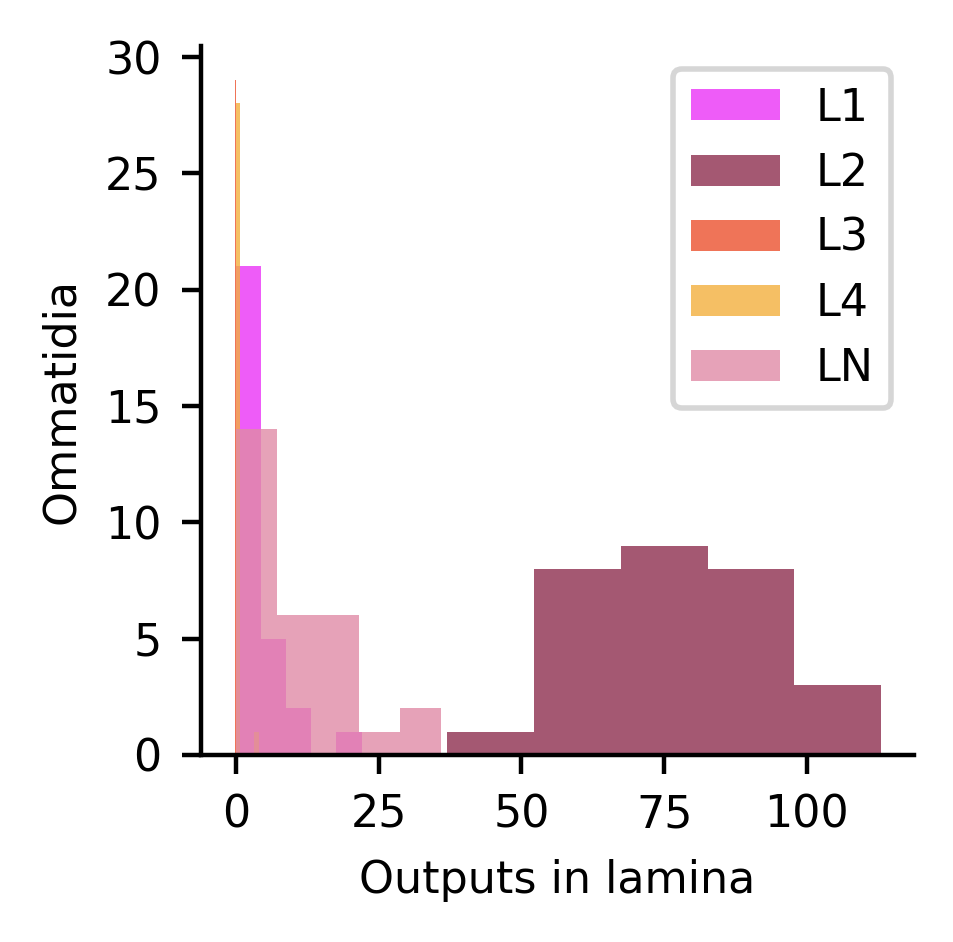

In [7]:
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])
for pre, rows in lmc_outputs.groupby('pre_type'):

    ax.hist(rows.out_to_all, color=c[pre], label=pre[0] + pre[-1], alpha=0.8, bins=5)
    
ax.set_xlabel('Outputs in lamina')
ax.set_ylabel('Ommatidia')
ax.legend()

if save_figs:
    fig.savefig(fig_path + 'LMC_outputs_all.svg')
    fig.savefig(fig_path + 'LMC_outputs_all.png')

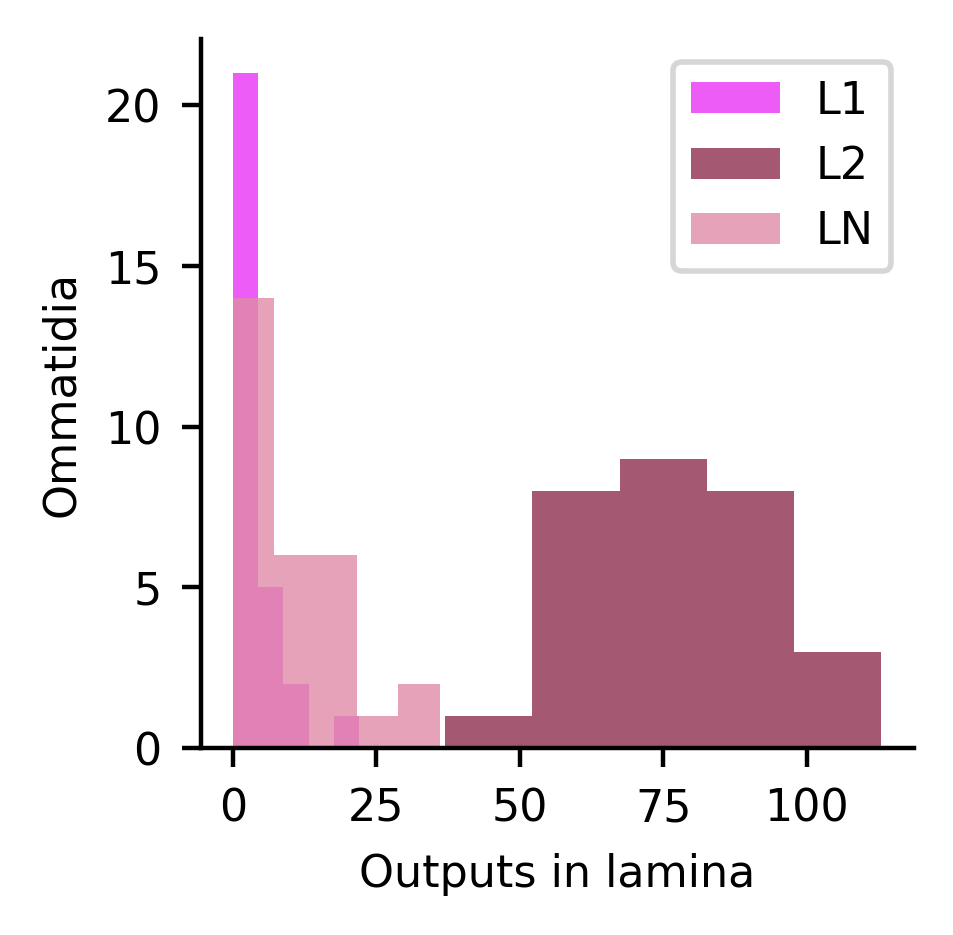

In [8]:
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])
for pre, rows in lmc_outputs.groupby('pre_type'):
    if pre in ['LMC_1', 'LMC_2', 'LMC_N']:
        ax.hist(rows.out_to_all, color=c[pre], label=pre[0] + pre[-1], alpha=0.8, bins=5)
    else:
        continue
    
ax.set_xlabel('Outputs in lamina')
ax.set_ylabel('Ommatidia')
ax.legend()

if save_figs:
    fig.savefig(fig_path + 'LMC_outputs_l1-2-N.svg')
    fig.savefig(fig_path + 'LMC_outputs_l1-2-N.png')

## Does L2 make significantly more outputs than L1 and L3?

Two sample Mann-Whitney U test (one tailed)

$$H_{0}: P(out_{L2} <= out_{L1 + L3}) >= 1/2$$
Probability that L2 makes less outputs than L1 or L3 is more than or equal to 50%
$$H_{1}: P(out_{L2} > out_{L1 + L3}) >= 1/2$$
Probability that L2 makes less outputs than L1 or L3 is less than 50%

In [10]:
l2_outs = lmc_outputs[lmc_outputs.index.get_level_values('pre_type') == 'LMC_2']['out_to_all']
l1_l3_outs = lmc_outputs[lmc_outputs.index.get_level_values('pre_type').isin(['LMC_1', 'LMC_3'])]['out_to_all']

results = mannwhitneyu(l2_outs, l1_l3_outs, alternative='greater', method='exact')
display(results)

TypeError: mannwhitneyu() got an unexpected keyword argument 'method'

ValueError: Could not interpret input 'pre_type'

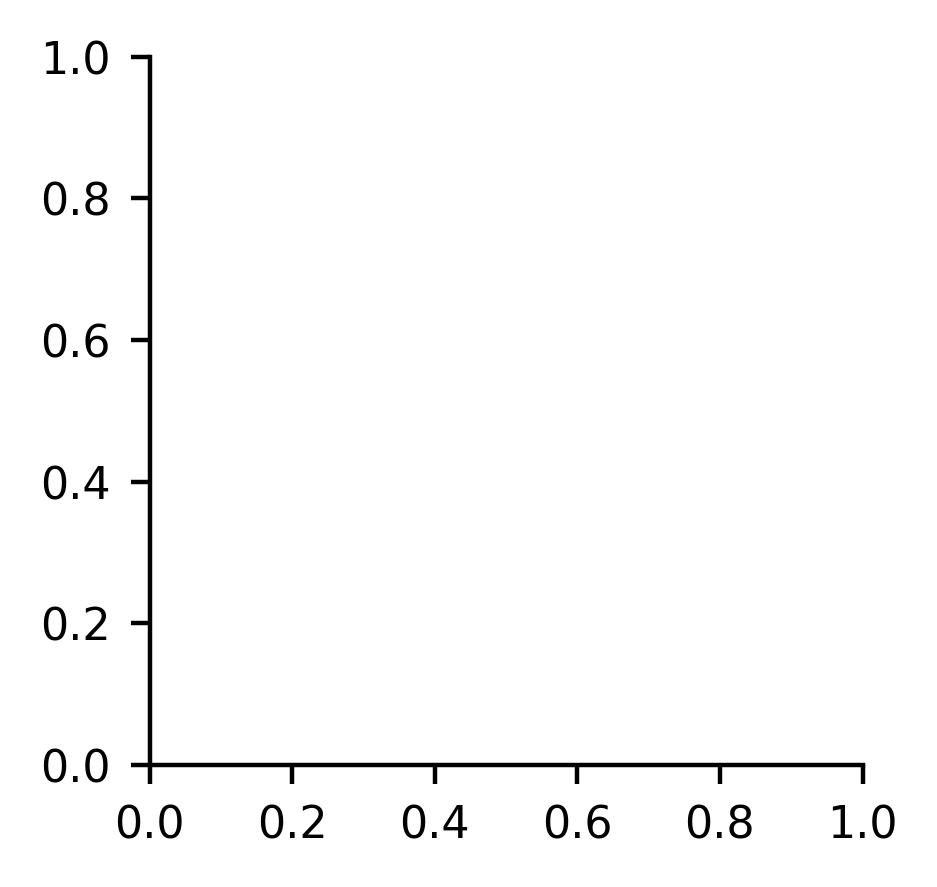

In [9]:
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

bp = sns.swarmplot(x='pre_type', y='out_to_all', data=lmc_outputs, ax=ax, palette=c)

#ax.boxplot( color=c[pre], label=pre[0] + pre[-1], alpha=0.7)
    
#ax.set_xlabel('')
ax.set_ylabel('Outputs')
ax.set_xticklabels(['L1', 'L2', 'L3', 'L4', 'LN'])

0.0
22.0
37.0
113.0
0.0
36.0


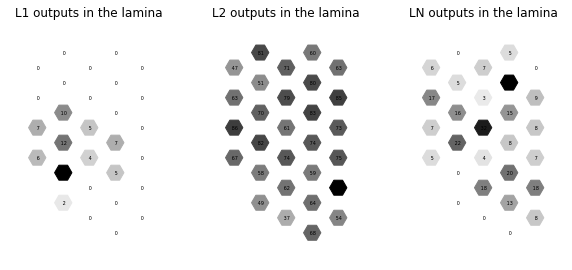

In [11]:
fig, ax = plt.subplots(1, 3, figsize=[10, 30])

cm = plt.cm.get_cmap('binary')
# L1 outputs
max_l1 = l1_out.sum(axis=1).max()
print(l1_out.sum(axis=1).min())
print(l1_out.sum(axis=1).max())
node_data = {o: {'colour': cm(l1_out.loc[o].sum()/max_l1),
                'label': f"{l1_out.loc[o].sum(): .0f}"
                } for o in ommatidia}
hexplot(node_data=node_data, ax=ax[0])
ax[0].set_title("L1 outputs in the lamina")
# L2 outputs 
max_l2 = l2_out.sum(axis=1).max()
print(l2_out.sum(axis=1).min())
print(l2_out.sum(axis=1).max())
node_data = {o: {'colour': cm(l2_out.loc[o].sum()/max_l2),
                'label': f"{l2_out.loc[o].sum(): .0f}"
                } for o in ommatidia}
hexplot(node_data=node_data, ax=ax[1])
ax[1].set_title("L2 outputs in the lamina")

max_ln = ln_out.sum(axis=1).max()
print(ln_out.sum(axis=1).min())
print(max_ln)
node_data = {o: {'colour': cm(ln_out.loc[o].sum()/max_ln),
                'label': f"{ln_out.loc[o].sum(): .0f}"
                } for o in ommatidia}
hexplot(node_data=node_data, ax=ax[2])
ax[2].set_title("LN outputs in the lamina")
plt.show()